In [113]:
import os
import pandas as pd
import glob
import matplotlib.pyplot as plt

In [78]:
"""
file format: {model}.{date}.{cycle}.{metric}.csv
create program to compare the forecasted degree days to the observed degree days as well
as the forecast for two days ahead compared to what it is forecasting for the same day the next day
"""

'\nfile format: {model}.{date}.{cycle}.{metric}.csv\ncreate program to compare the forecasted degree days to the observed degree days as well\nas the forecast for two days ahead compared to what it is forecasting for the same day the next day\n'

In [79]:
path = "RawData"

In [80]:
files = glob.glob(path + '/ecmwf-eps.*.pw_cdd.csv')

In [81]:
sorted_files = sorted(files, key=lambda x: (x.split('.')[1], x.split('.')[2]))

### actual vs forecasted for the first forecasted day

In [140]:
errors_list = []
errors = {}
forecasts = {}
observed = {}
for i in range(0, len(sorted_files)-1):
    df1 = pd.read_csv(sorted_files[i])
    forecast = df1[df1.iloc[:, 2] == 1].iloc[0]['Value']
    forecast_date = df1[df1.iloc[:, 2] == 1].iloc[0]['Date']

    df2 = pd.read_csv(sorted_files[i+1])
    observation = df2[df2.iloc[:, 2] == 0].iloc[-1]['Value']
    observation_date = df2[df2.iloc[:, 2] == 0].iloc[-1]['Date']

    error = observation - forecast

    errors[forecast_date] = error
    forecasts[forecast_date] = forecast
    observed[observation_date] = observation
    errors_list.append(error)

In [141]:
mean_error = sum(errors.values())/len(errors.values())

In [142]:
mean_error

0.02206426155580602

In [143]:
errors = pd.DataFrame.from_dict(errors, orient='index')
forecasts = pd.DataFrame.from_dict(forecasts, orient='index')
observed = pd.DataFrame.from_dict(observed, orient='index')

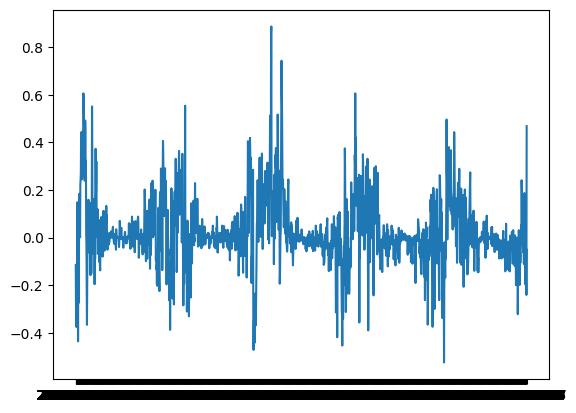

In [144]:
fig, ax = plt.subplots()
ax.plot(errors.index, errors[0], label='error')
plt.show()

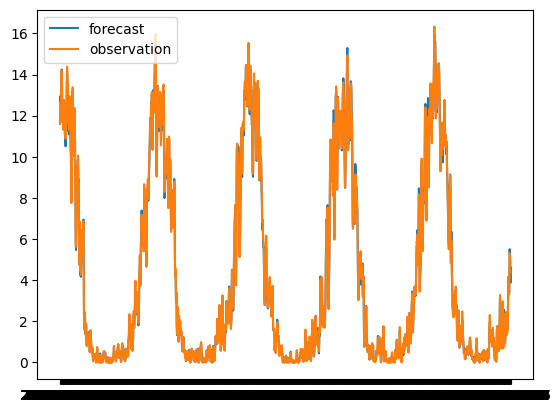

In [145]:
fig, ax = plt.subplots()
#ax.plot(errors.index, errors[0], label='error')
ax.plot(forecasts.index, forecasts[0], label='forecast')
ax.plot(observed.index, observed[0], label='observation')
ax.legend()
plt.show()

In [146]:
forecasts = forecasts.rename(columns={0: 'forecast'})
observed = observed.rename(columns={0: 'observation'})
errors = errors.rename(columns={0: 'error'})

In [147]:
master_df = pd.concat([forecasts, observed, errors], axis=1)

In [148]:
master_df

,forecast,observation,error
2018-07-09,11.712,11.597,-0.115
2018-07-10,12.936,12.628,-0.308
2018-07-11,12.566,12.273,-0.293
2018-07-12,12.706,12.330,-0.376
2018-07-13,13.287,13.026,-0.261
...,...,...,...
2023-05-13,5.253,5.225,-0.078
2023-05-14,5.049,4.958,-0.184
2023-05-15,4.360,4.431,-0.047
2023-05-16,4.613,4.372,-0.241
